# Training and testing model

### Importing relevant Libararies, Objects and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys, os
sys.path.append(os.path.abspath(".."))

from sklearn.metrics import confusion_matrix #Add confusion matrix later

from src.train import TrainingAlgorithm, evaluate
from src.model import model
from src.utils import load_train_val_loaders

### Training Model

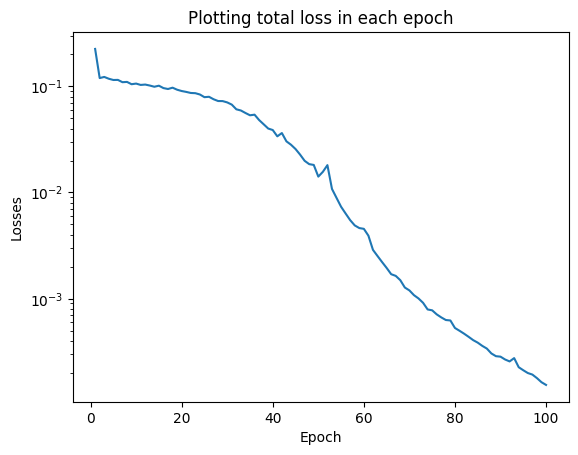

In [2]:
train_loader, val_loader = load_train_val_loaders("data")

m = model(load_weights=False)
losses = TrainingAlgorithm(m, train_loader, num_epochs=100, device="cpu") 

epochs = np.arange(1, len(losses)+1)

plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.yscale("log")
plt.plot(epochs, losses)
plt.title("Plotting total loss in each epoch")
plt.show()

### Testing on Validation Set

In [3]:
val_loss, val_acc = evaluate(m, val_loader)
print("Val loss:", val_loss)
print("Val accuracy:", val_acc)

Val loss: 0.5580736510455608
Val accuracy: 0.953


### Testing submission

model.pred() needs to take the same input as the training data and output must be a one-dimensional tensor with the prediction of each input sample.

In [4]:
m_test = model() #Need to fix that it can get weights from model_weights.pth
X = torch.load("data\input_data.pt")

y = m_test.pred(X)
print(y)

#Should be 0 and 1, and does not manage to get weights
#Should try to get the model to get it, and the traning to set it random and update it

Loaded pretrained weights from: c:\Users\oskar\ML_course_homeworks\ML4Physics_homework1\models\model_weights.pth
tensor([8.8815e-14, 1.1878e-22, 1.0000e+00,  ..., 1.1195e-08, 1.1586e-11,
        4.4862e-19])
